In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.misc import imresize
import cv2
import time

In [2]:
directory = 'image_contest_level_1/'
images = [i for i in os.listdir(directory) if i.find('labels')<0]
images.sort()
with open(directory+'labels.txt','r') as fopen:
    labels = [i.split()[0] for i in list(filter(None,fopen.read().split('\n')))]
images = images[:30]
labels = labels[:30]
len(images)
len(labels)

30

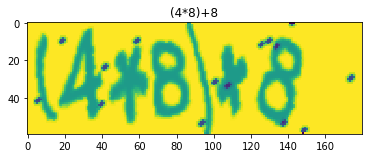

In [3]:
plt.imshow(cv2.imread(directory+images[0], 0).astype(np.float32)/255.)
plt.title(labels[0])
plt.show()

In [4]:
charset = '0123456789+-*()'
num_classes = len(charset) + 2
encode_maps = {}
decode_maps = {}
for i, char in enumerate(charset, 1):
    encode_maps[char] = i
    decode_maps[i] = char

SPACE_INDEX = 0
SPACE_TOKEN = ''
encode_maps[SPACE_TOKEN] = SPACE_INDEX
decode_maps[SPACE_INDEX] = SPACE_TOKEN

In [5]:
[SPACE_INDEX if labels[0] == SPACE_TOKEN else encode_maps[c] for c in labels[0]]

[14, 5, 13, 9, 15, 11, 9]

In [6]:
image_height = 60
image_width = 180
image_channel = 1
max_stepsize = 64
num_hidden = 128
epoch = 500
batch_size = 10
initial_learning_rate = 1e-2

In [7]:
class Model:
    def __init__(self):
        self.X = tf.placeholder(tf.float32, [None, image_height, image_width, image_channel])
        self.Y = tf.sparse_placeholder(tf.int32)
        self.SEQ_LEN = tf.placeholder(tf.int32, [None])
        filters = [64, 128, 128, max_stepsize]
        strides = [1, 2]
        x = self.conv2d(self.X, 'cnn-1', 3, 1, filters[0], strides[0])
        x = self.batch_norm('bn1', x)
        x = self.leaky_relu(x, 0.01)
        x = self.max_pool(x, 2, strides[1])
        x = self.conv2d(x, 'cnn-2', 3, filters[0], filters[1], strides[0])
        x = self.batch_norm('bn2', x)
        x = self.leaky_relu(x, 0.01)
        x = self.max_pool(x, 2, strides[1])
        x = self.conv2d(x, 'cnn-3', 3, filters[1], filters[2], strides[0])
        x = self.batch_norm('bn3', x)
        x = self.leaky_relu(x, 0.01)
        x = self.max_pool(x, 2, strides[1])
        x = self.conv2d(x, 'cnn-4', 3, filters[2], filters[3], strides[0])
        x = self.batch_norm('bn4', x)
        x = self.leaky_relu(x, 0.01)
        x = self.max_pool(x, 2, strides[1])
        x = tf.reshape(x, [batch_size, -1, filters[3]])
        x = tf.transpose(x, [0, 2, 1])
        x.set_shape([batch_size, filters[3], 48])
        cell = tf.contrib.rnn.LSTMCell(num_hidden, state_is_tuple=True)
        cell = tf.contrib.rnn.DropoutWrapper(cell=cell, output_keep_prob=0.8)
        cell1 = tf.contrib.rnn.LSTMCell(num_hidden, state_is_tuple=True)
        cell1 = tf.contrib.rnn.DropoutWrapper(cell=cell1, output_keep_prob=0.8)
        stack = tf.contrib.rnn.MultiRNNCell([cell, cell1], state_is_tuple=True)
        outputs, _ = tf.nn.dynamic_rnn(stack, x, self.SEQ_LEN, dtype=tf.float32)
        outputs = tf.reshape(outputs, [-1, num_hidden])
        W = tf.get_variable(name='W',
                            shape=[num_hidden, num_classes],
                            dtype=tf.float32,
                            initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable(name='b',
                            shape=[num_classes],
                            dtype=tf.float32,
                            initializer=tf.constant_initializer())
        self.logits = tf.matmul(outputs, W) + b
        shape = tf.shape(x)
        self.logits = tf.reshape(self.logits, [shape[0], -1, num_classes])
        self.logits = tf.transpose(self.logits, (1, 0, 2))
        self.global_step = tf.Variable(0, trainable=False)
        self.loss = tf.nn.ctc_loss(labels=self.Y,
                                   inputs=self.logits,
                                   sequence_length=self.SEQ_LEN)
        self.cost = tf.reduce_mean(self.loss)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=initial_learning_rate).minimize(self.cost)
        self.decoded, self.log_prob = tf.nn.ctc_beam_search_decoder(self.logits,
                                                                    self.SEQ_LEN,
                                                                    merge_repeated=False)
        self.dense_decoded = tf.sparse_tensor_to_dense(self.decoded[0], default_value=-1)
        
        
    def conv2d(self, x, name, filter_size, channel_in, channel_out, strides):
        with tf.variable_scope(name):
            kernel = tf.get_variable(name='W',
                                     shape=[filter_size, filter_size, channel_in, channel_out],
                                     dtype=tf.float32,
                                     initializer=tf.contrib.layers.xavier_initializer())
            b = tf.get_variable(name='b',
                                shape=[channel_out,],
                                dtype=tf.float32,
                                initializer=tf.constant_initializer())
            return tf.nn.conv2d(x, kernel, [1, strides, strides, 1], padding='SAME') + b
    
    def batch_norm(self, name, x):
        with tf.variable_scope(name):
            params_shape = [x.get_shape()[-1]]
            beta = tf.get_variable('beta', params_shape, tf.float32,
                                   initializer=tf.constant_initializer(0.0, tf.float32))
            gamma = tf.get_variable('gamma', params_shape, tf.float32,
                                    initializer=tf.constant_initializer(1.0, tf.float32))
            mean, variance = tf.nn.moments(x, [0, 1, 2], name='moments')
            x_bn = tf.nn.batch_normalization(x, mean, variance, beta, gamma, 0.001)
            x_bn.set_shape(x.get_shape())
            return x_bn
        
    def leaky_relu(self, x, leak=0):
        return tf.where(tf.less(x, 0.0), leak * x, x, name='leaky_relu')
    
    def max_pool(self, x, size, strides):
        return tf.nn.max_pool(x, 
                              ksize=[1, size, size, 1],
                              strides=[1, strides, strides, 1],
                              padding='SAME',
                              name='max_pool')

In [8]:
def accuracy_calculation(original_seq, decoded_seq, ignore_value=-1):
    count = 0
    for i, origin_label in enumerate(original_seq):
        decoded_label = [j for j in decoded_seq[i] if j != ignore_value]
        if origin_label == decoded_label:
            count += 1
    return count * 1.0 / len(original_seq)

def sparse_tuple_from_label(sequences, dtype=np.int32):
    indices, values = [], []
    for n, seq in enumerate(sequences):
        indices.extend(zip([n] * len(seq), range(len(seq))))
        values.extend(seq)
    indices = np.asarray(indices, dtype=np.int64)
    values = np.asarray(values, dtype=dtype)
    shape = np.asarray([len(sequences), np.asarray(indices).max(0)[1] + 1], dtype=np.int64)
    return indices, values, shape

In [9]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model()
sess.run(tf.global_variables_initializer())

In [10]:
for i in range(epoch):
    total_lost, total_acc = 0, 0
    last_time = time.time()
    for k in range(0, (len(images)//batch_size)*batch_size, batch_size):
        batch_x = np.zeros((batch_size,image_height, image_width, image_channel))
        batch_label = []
        for n in range(batch_size):
            batch_x[n] = (cv2.imread(directory+images[k+n], 0).astype(np.float32)/255.).reshape((60,180,1))
            batch_label.append([SPACE_INDEX if labels[0] == SPACE_TOKEN else encode_maps[c] for c in labels[k+n]])
        batch_len = np.asarray([max_stepsize for _ in [1]*batch_size], dtype=np.int64)
        batch_y = sparse_tuple_from_label(batch_label)
        feed = {model.X: batch_x,
                model.Y: batch_y,
                model.SEQ_LEN: batch_len}
        decoded, loss, _ = sess.run([model.dense_decoded,model.cost,model.optimizer],
                                    feed_dict = feed)
        acc = accuracy_calculation(batch_label, decoded,ignore_value=-1)
        total_lost += loss
        total_acc += acc
    total_lost /= (len(images)//batch_size)
    total_acc /= (len(images)//batch_size)
    if (i+1) % 100 == 0:
        print('epoch %d, avg loss %f, avg acc %f, time taken %f s'%(i+1,total_lost,total_acc,time.time()-last_time))

epoch 100, avg loss 2.157805, avg acc 0.400000, time taken 0.350654 s
epoch 200, avg loss 0.076817, avg acc 1.000000, time taken 0.347520 s
epoch 300, avg loss 0.027402, avg acc 1.000000, time taken 0.349331 s
epoch 400, avg loss 0.022630, avg acc 1.000000, time taken 0.344544 s
epoch 500, avg loss 0.182347, avg acc 0.933333, time taken 0.345036 s


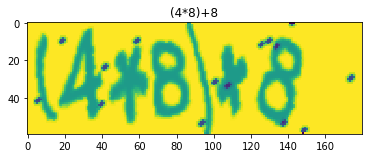

In [21]:
batch_x = np.zeros((batch_size,image_height, image_width, image_channel))
for n in range(batch_size):
    batch_x[n] = (cv2.imread(directory+images[n], 0).astype(np.float32)/255.).reshape((60,180,1))
batch_len = np.asarray([max_stepsize for _ in [1]*batch_size], dtype=np.int64)
decoded = sess.run(model.dense_decoded, feed_dict = {model.X:batch_x,model.SEQ_LEN:batch_len})
plt.imshow(cv2.imread(directory+images[0], 0).astype(np.float32)/255.)
plt.title(''.join([decode_maps[i] for i in decoded[0]]))
plt.show()